In [151]:
import torch
from training.FiretraceMLP import FiretraceMLP

checkpoint = torch.load("../models/firetrace_model.pt")

model = FiretraceMLP(width=checkpoint['model_size'][0], depth=checkpoint['model_size'][1])
compiled_model = torch.compile(model, fullgraph=True, mode="max-autotune")

compiled_model.load_state_dict(checkpoint['model_state_dict'])
compiled_model.eval()

OptimizedModule(
  (_orig_mod): FiretraceMLP(
    (layers): ModuleList(
      (0): Linear(in_features=9, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): ReLU()
      (4): Linear(in_features=50, out_features=50, bias=True)
      (5): ReLU()
      (6): Linear(in_features=50, out_features=50, bias=True)
      (7): ReLU()
      (8): Linear(in_features=50, out_features=50, bias=True)
      (9): ReLU()
      (10): Linear(in_features=50, out_features=50, bias=True)
      (11): ReLU()
      (12): Linear(in_features=50, out_features=1, bias=True)
    )
  )
)

In [152]:
import pandas as pd

df = pd.read_csv("../data/gen_2/processed/with_fire_area_soi_weather_time.csv")

# Pick last x rows
df = df.tail(3500)

y = df["fire_area"]
y = y.reset_index()["fire_area"]
X = df.drop("fire_area", axis=1)

In [153]:
import joblib

x_scaler = joblib.load("../models/x_scaler.save")
y_scaler = joblib.load("../models/y_scaler.save")

x_scaled = x_scaler.transform(X)

In [154]:
print(x_scaled[0].shape)

(9,)


In [155]:
individual_output = compiled_model(torch.tensor(x_scaled[70], dtype=torch.float32).reshape(1, -1))
individual_output_unscaled = y_scaler.inverse_transform(individual_output.detach().numpy().reshape(1, -1))

print("Predicted fire area: ", individual_output_unscaled)

print("Actual fire area: ", y[70])

Predicted fire area:  [[106.68076]]
Actual fire area:  109.93


In [156]:
test_output = compiled_model(torch.tensor(x_scaled, dtype=torch.float32))

test_output

tensor([[0.0484],
        [0.0402],
        [0.0396],
        ...,
        [0.0029],
        [0.0018],
        [0.0079]], grad_fn=<CompiledFunctionBackward>)

In [157]:
# Unscale the output

y_unscaled = y_scaler.inverse_transform(test_output.detach().numpy())

y_unscaled

array([[642.2137  ],
       [532.85455 ],
       [525.1301  ],
       ...,
       [ 39.56835 ],
       [ 24.450878],
       [105.32852 ]], dtype=float32)

In [158]:
# Calculate MAE

from sklearn.metrics import mean_absolute_error

mean_absolute_error(y, y_unscaled)

247.42228518217087

Text(0, 0.5, 'Fire Area (sqkm)')

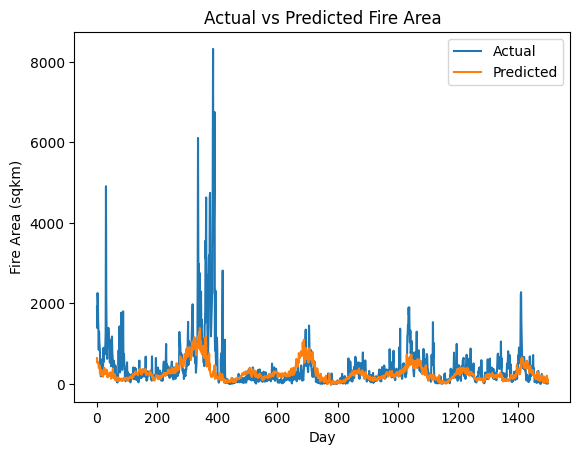

In [159]:
# Graph output vs actual

import matplotlib.pyplot as plt

plt.plot(y, label="Actual")
plt.plot(y_unscaled, label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Fire Area")
plt.xlabel("Day")
plt.ylabel("Fire Area (sqkm)")

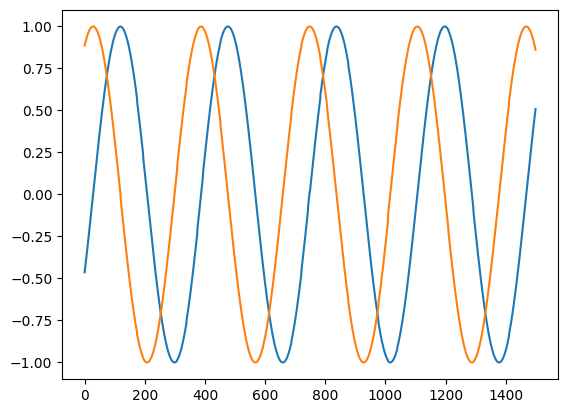

In [160]:
plt.plot(X['sin_signal'].to_numpy())
plt.plot(X['cos_signal'].to_numpy())

